##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [52]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from itertools import combinations
from functools import partial

from multiprocessing import Pool

from scipy.stats import norm
from scipy import stats

# from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# from sklearn.model_selection import RepeatedKFold, WhiteKernel, ConstantKernel

## Personal Modules
import ReadStandardTimeFill as RSTF
import RepRunner as RR
# import LSTM
import Dense

import importlib
# importlib.reload(LSTM)
# importlib.reload(Dense)
importlib.reload(RR)
# importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

# pool.close()

In [37]:

Path = 'Data_Footprints_2018-05-10.csv'

FillVar = 'fco2'

FP_Model = ['Grass','Water','Shrub','Sedge','Sparse','Upland',
     'Ocean','Fen','Out_of_Basin'] 

Runs,params = RR.Params(Path,'Test',FillVar,FP_Model,MP=False)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
Runs['CI'] = 0.0
print(Runs)

     N  MSE  STD   CI
0   50  0.0  0.0  0.0
1  100  0.0  0.0  0.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.777851881261
Finisehed Run  1  MSE:  0.757165467675


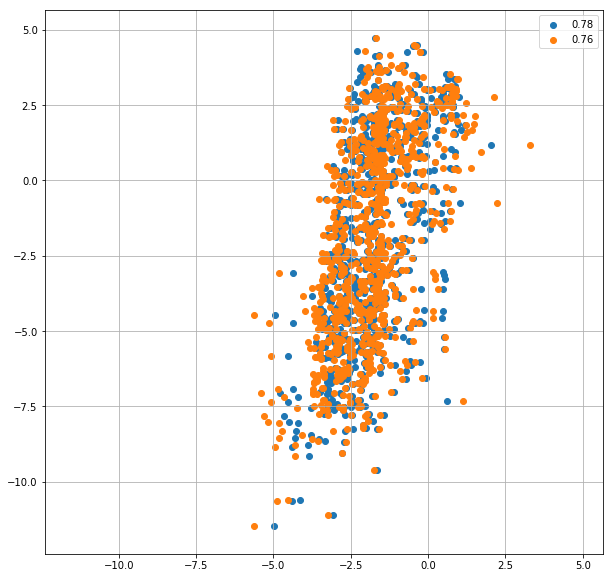

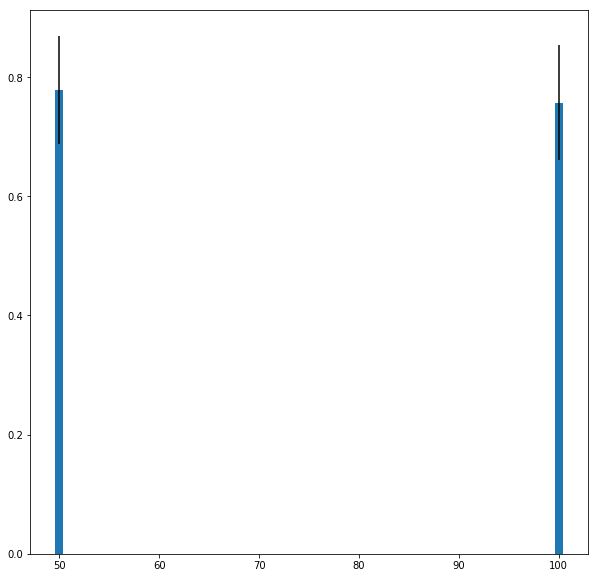

In [39]:



# AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
#          'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

# FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','Rain','Water Table']

# FullModel = ['wind_speed','Sedge','Shrub','PPFD_Avg','Temp','AirTC_Avg','u*','air_pressure','VWC','Z_L','VPD']

Time = time.time()

plt.figure(figsize=(10,10))

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RR.RunReps(params,Path,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

plt.grid()
plt.legend()
Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    

In [53]:
Runs = RR.GP(params,Path,Runs,pool)


print(Runs)

# plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

96


ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [ ]:
try:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    
plt.grid()
print(Runs)
Optimum = Runs[Runs['MSE'] <= Runs['Upper_Bounds'].min()]
# print(Optimum)
Optimum = Optimum[Optimum['N'] == Optimum['N'].min()]

print('Optimum:')
print(Optimum)


# Feature Identification

In [ ]:
BestMSE = []
BestSTD = []
idx = []
BestModels = []

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
params['N']=Optimum['N'].values[0]
# print(Optimum)

print(FullModel)
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
# print(Scores)
Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})
# print(ModelRuns)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     Score = []
#     STD = []
#     Model_Names = []
    
    for i,model in enumerate(Models):
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+'+'.join(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
        level = len(model)
        key = str(level)+'_'+str(i)
        d = {'Model':'+'.join(model),
             'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+CI,
                'Key':key}
        score = pd.DataFrame(index=[0],data=d)
        print(model,' Upper Bound ',mean+CI)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]
        
    Level = Scores.loc[Scores['Level'] == level]
    Lowest_Yet = Scores.loc[Scores['Level']<= level]['Upper_Bounds'].min()
    Best = Level.loc[Level['MSE']<=Lowest_Yet]['Model'].values
    print(Best)
#     print(ModelRuns)
#         print(model,MSE)
#         Score.append(MSE.mean())
#         STD.append(MSE.std())
#         Model_Names.append('Model: '+'+'.join(model))
        
#     Score = np.asanyarray(Score)
#     STD = np.asanyarray(STD)
#     Best = Models[np.where(Score == Score.min())[0][0]]
#     Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
#     BestModels.append(Best_Name)
#     BestMSE.append(Score.min())
#     BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
#     idx.append(i)
#     print('Best:')
#     print(Best,Score.min())
# BestModels = np.asanyarray(BestModels)
# BestMSE = np.asanyarray(BestMSE)
# BestSTD = np.asanyarray(BestSTD)
# idx = np.asanyarray(idx)
# BestSE = BestSTD/(params['reps']**.5)
# BestCI = BestSE*1.96
# plt.figure(figsize=(10,10))
# plt.bar(idx,BestMSE)
# plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

# d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
# Stats = pd.DataFrame(index=idx,data=d)
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

ModelRuns.to_csv('GapFilled'+FillVar+'.csv')



In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        